# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

## Caveats:

- The confirmed cases reported by each country are different from the number of infected people in each country.


- **The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infected people.** For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as the same rate.


- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.


- The growth rate (or recent doubling time) changes with time, and will eventually fall to zero. So be cautious about extrapolating trends into the future based on current growth rates. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/19/20


,3/19/20
Country/Region,
China,81156
Italy,41035
Iran,18407
Spain,17963
Germany,15320
US,13677
France,10947
"Korea, South",8565
Switzerland,4075


## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 81156
	Confirmed cases on 3/12/20 	 80932
	Ratio: 1.0
	Weekly increase: 0.3 %
	Daily increase: 0.0 % per day
	Doubling Time (represents recent growth): 1755.5 days

** Based on Logistic Fit**

	R^2: 0.995310191322
	Doubling Time (during middle of growth):  6.46 (± 0.54 ) days


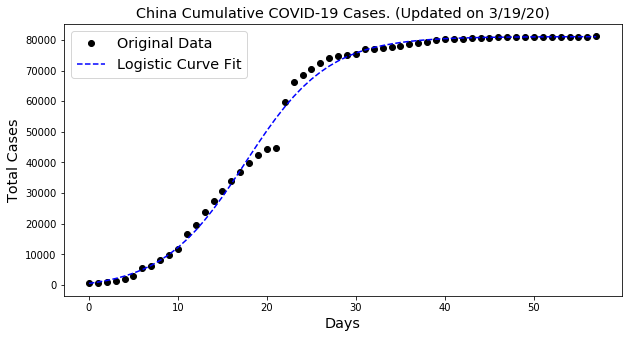



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 41035
	Confirmed cases on 3/12/20 	 12462
	Ratio: 3.29
	Weekly increase: 229.3 %
	Daily increase: 18.6 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.998528740689
	Doubling Time (during middle of growth):  6.57 (± 0.42 ) days

** Based on Exponential Fit **

	R^2: 0.994904665589
	Doubling Time (represents overall growth):  4.38 (± 0.2 ) days


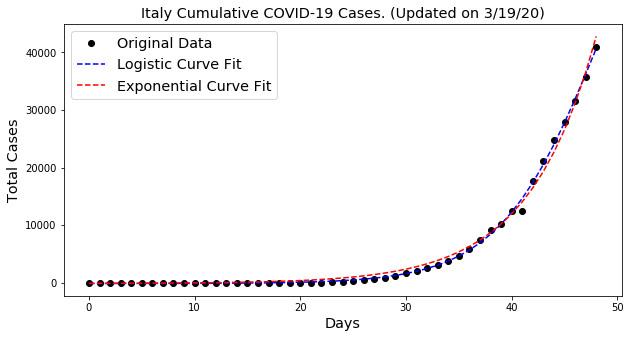



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 18407
	Confirmed cases on 3/12/20 	 10075
	Ratio: 1.83
	Weekly increase: 82.7 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.1 days

** Based on Logistic Fit**

	R^2: 0.997433837882
	Doubling Time (during middle of growth):  7.09 (± 0.86 ) days


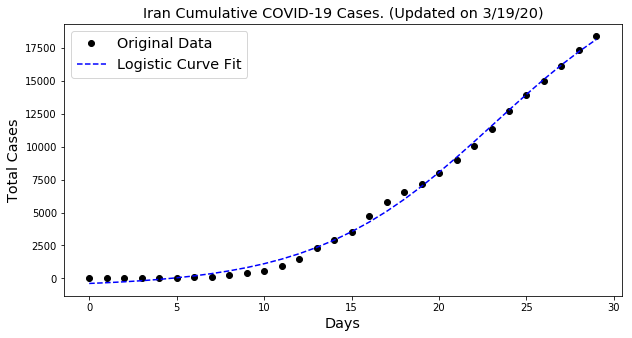



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 17963
	Confirmed cases on 3/12/20 	 2277
	Ratio: 7.89
	Weekly increase: 688.9 %
	Daily increase: 34.3 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Exponential Fit **

	R^2: 0.991346793986
	Doubling Time (represents overall growth):  2.96 (± 0.17 ) days


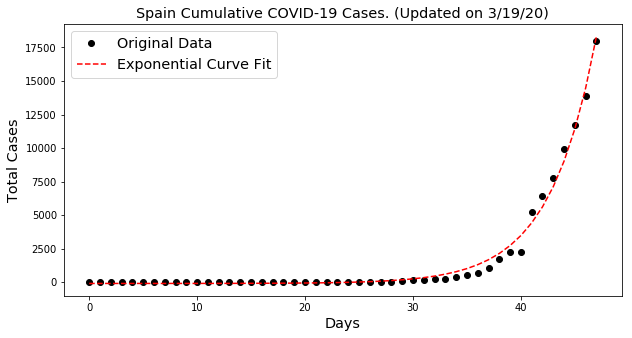



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 15320
	Confirmed cases on 3/12/20 	 2078
	Ratio: 7.37
	Weekly increase: 637.2 %
	Daily increase: 33.0 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Exponential Fit **

	R^2: 0.998704250757
	Doubling Time (represents overall growth):  2.75 (± 0.06 ) days


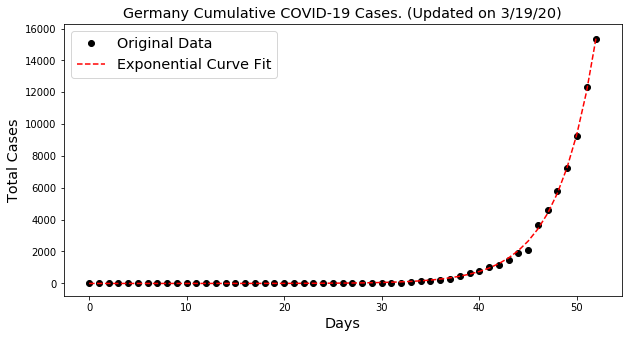



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 13677
	Confirmed cases on 3/12/20 	 1663
	Ratio: 8.22
	Weekly increase: 722.4 %
	Daily increase: 35.1 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Exponential Fit **

	R^2: 0.988538919187
	Doubling Time (represents overall growth):  2.09 (± 0.12 ) days


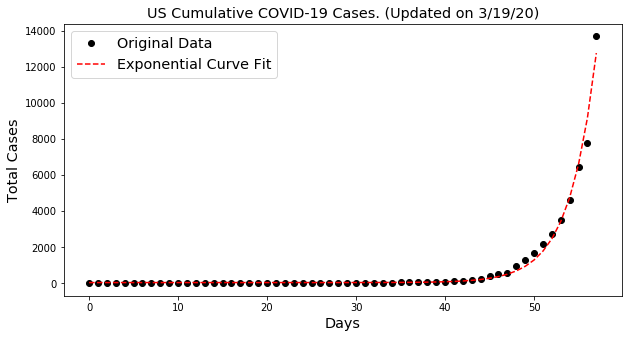



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 10947
	Confirmed cases on 3/12/20 	 2290
	Ratio: 4.78
	Weekly increase: 378.0 %
	Daily increase: 25.0 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.995313674125
	Doubling Time (represents overall growth):  3.44 (± 0.13 ) days


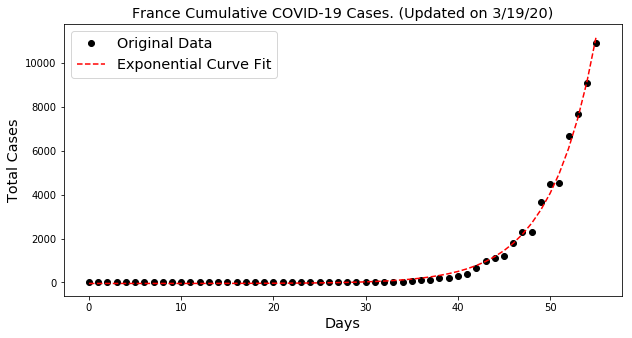



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 8565
	Confirmed cases on 3/12/20 	 7869
	Ratio: 1.09
	Weekly increase: 8.8 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 57.2 days

** Based on Logistic Fit**

	R^2: 0.999260259155
	Doubling Time (during middle of growth):  4.21 (± 0.15 ) days


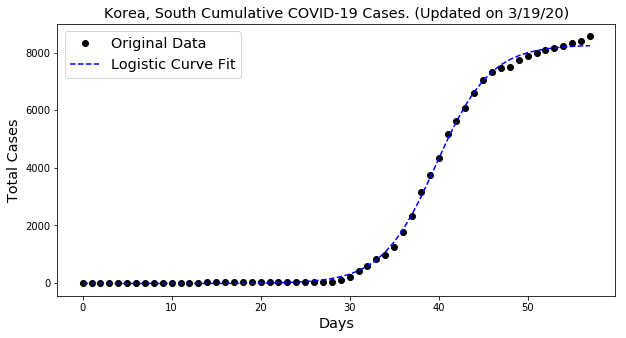



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 4075
	Confirmed cases on 3/12/20 	 652
	Ratio: 6.25
	Weekly increase: 525.0 %
	Daily increase: 29.9 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.989295175514
	Doubling Time (during middle of growth):  5.08 (± 1.53 ) days

** Based on Exponential Fit **

	R^2: 0.987855654232
	Doubling Time (represents overall growth):  3.4 (± 0.39 ) days


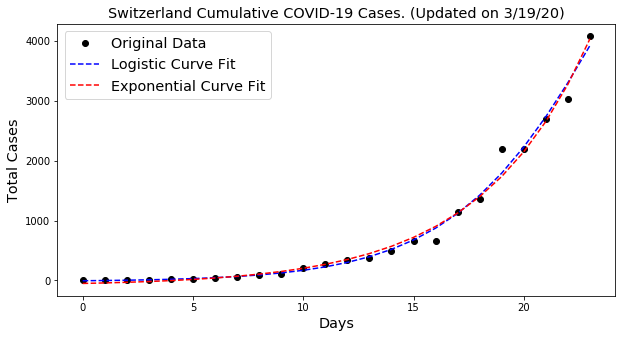



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 2716
	Confirmed cases on 3/12/20 	 459
	Ratio: 5.92
	Weekly increase: 491.7 %
	Daily increase: 28.9 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.989920827309
	Doubling Time (represents overall growth):  3.19 (± 0.19 ) days


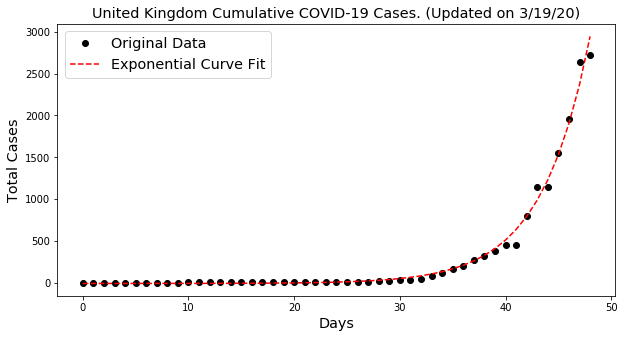



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 2467
	Confirmed cases on 3/12/20 	 503
	Ratio: 4.9
	Weekly increase: 390.5 %
	Daily increase: 25.5 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.998366383637
	Doubling Time (during middle of growth):  6.27 (± 0.98 ) days

** Based on Exponential Fit **

	R^2: 0.997989551502
	Doubling Time (represents overall growth):  3.72 (± 0.2 ) days


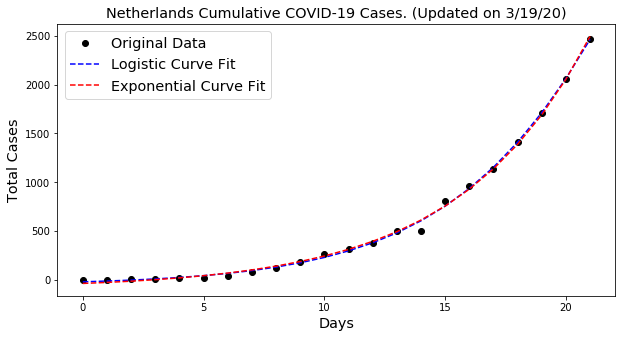



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 2013
	Confirmed cases on 3/12/20 	 302
	Ratio: 6.67
	Weekly increase: 566.6 %
	Daily increase: 31.1 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.998918174225
	Doubling Time (during middle of growth):  4.31 (± 0.38 ) days

** Based on Exponential Fit **

	R^2: 0.996569160675
	Doubling Time (represents overall growth):  2.97 (± 0.17 ) days


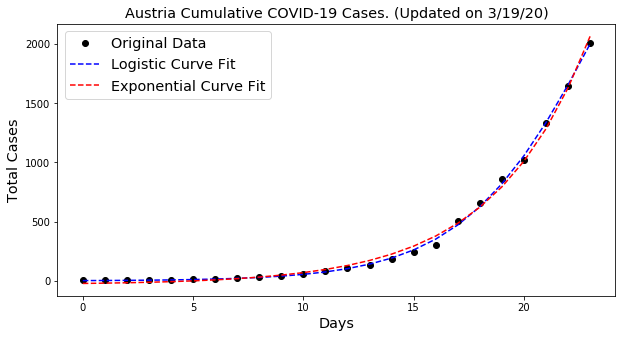



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 1795
	Confirmed cases on 3/12/20 	 314
	Ratio: 5.72
	Weekly increase: 471.7 %
	Daily increase: 28.3 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.994554379346
	Doubling Time (represents overall growth):  3.4 (± 0.16 ) days


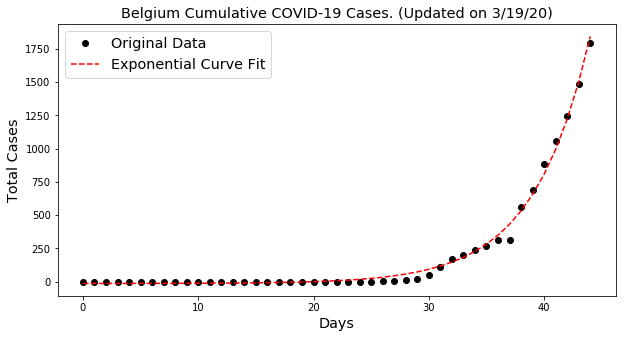



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 1746
	Confirmed cases on 3/12/20 	 702
	Ratio: 2.49
	Weekly increase: 148.7 %
	Daily increase: 13.9 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.995309166749
	Doubling Time (during middle of growth):  3.41 (± 0.51 ) days

** Based on Exponential Fit **

	R^2: 0.962454311889
	Doubling Time (represents overall growth):  4.85 (± 1.28 ) days


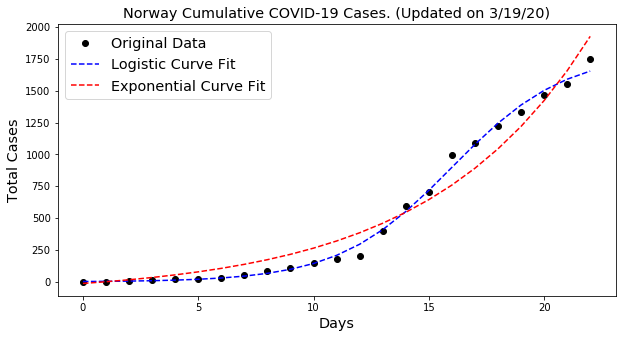



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 1439
	Confirmed cases on 3/12/20 	 599
	Ratio: 2.4
	Weekly increase: 140.2 %
	Daily increase: 13.3 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.997439292732
	Doubling Time (during middle of growth):  3.66 (± 0.26 ) days

** Based on Exponential Fit **

	R^2: 0.968556316359
	Doubling Time (represents overall growth):  4.69 (± 0.53 ) days


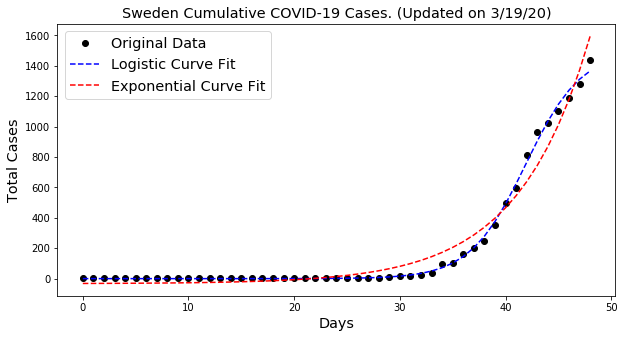



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 1225
	Confirmed cases on 3/12/20 	 617
	Ratio: 1.99
	Weekly increase: 98.5 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.987544588832
	Doubling Time (during middle of growth):  2.37 (± 0.56 ) days


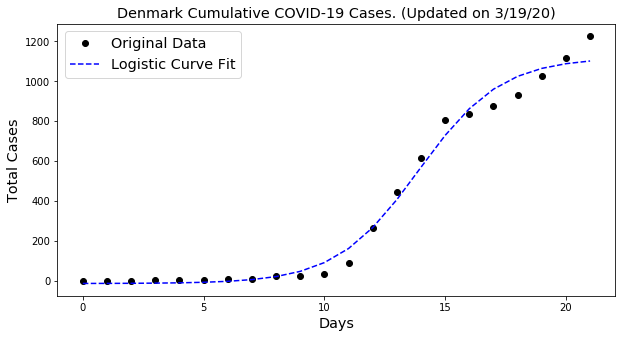



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 924
	Confirmed cases on 3/12/20 	 639
	Ratio: 1.45
	Weekly increase: 44.6 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.2 days

** Based on Logistic Fit**

	R^2: 0.997488563815
	Doubling Time (during middle of growth):  11.15 (± 0.86 ) days

** Based on Exponential Fit **

	R^2: 0.990014063754
	Doubling Time (represents overall growth):  10.36 (± 0.73 ) days


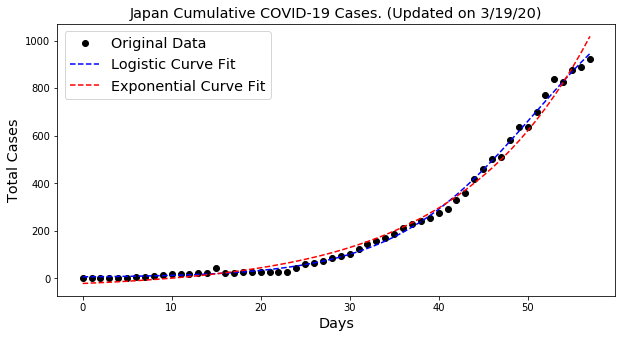



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 900
	Confirmed cases on 3/12/20 	 149
	Ratio: 6.04
	Weekly increase: 504.0 %
	Daily increase: 29.3 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.985807658236
	Doubling Time (represents overall growth):  3.03 (± 0.2 ) days


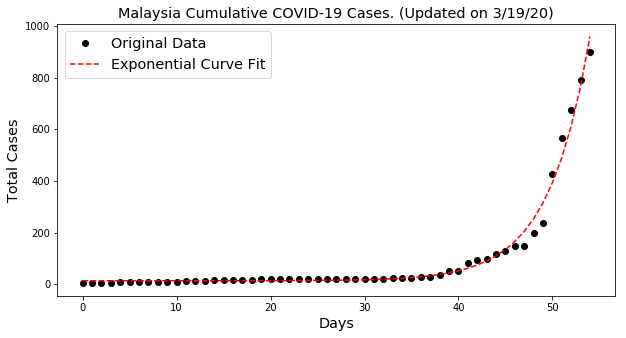



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 800
	Confirmed cases on 3/12/20 	 117
	Ratio: 6.84
	Weekly increase: 583.8 %
	Daily increase: 31.6 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Exponential Fit **

	R^2: 0.994950820888
	Doubling Time (represents overall growth):  2.65 (± 0.11 ) days


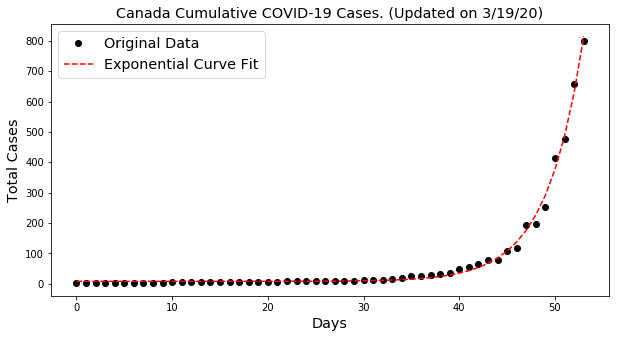



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 785
	Confirmed cases on 3/12/20 	 59
	Ratio: 13.31
	Weekly increase: 1230.5 %
	Daily increase: 44.7 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Logistic Fit**

	R^2: 0.979574101962
	Doubling Time (during middle of growth):  4.64 (± 3.23 ) days

** Based on Exponential Fit **

	R^2: 0.979574104257
	Doubling Time (represents overall growth):  2.32 (± 0.4 ) days


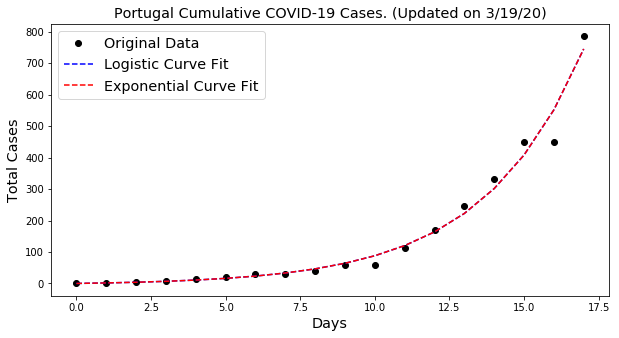



Cruise Ship

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 712
	Confirmed cases on 3/12/20 	 696
	Ratio: 1.02
	Weekly increase: 2.3 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 213.5 days

** Based on Logistic Fit**

	R^2: 0.995655096777
	Doubling Time (during middle of growth):  2.7 (± 0.28 ) days


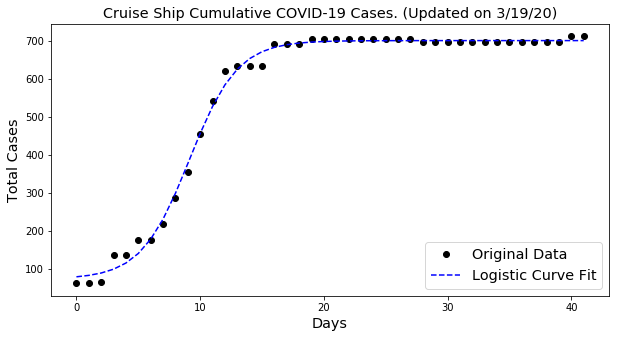



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 694
	Confirmed cases on 3/12/20 	 94
	Ratio: 7.38
	Weekly increase: 638.3 %
	Daily increase: 33.1 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.993300862074
	Doubling Time (during middle of growth):  5.3 (± 1.88 ) days

** Based on Exponential Fit **

	R^2: 0.993300863504
	Doubling Time (represents overall growth):  2.65 (± 0.26 ) days


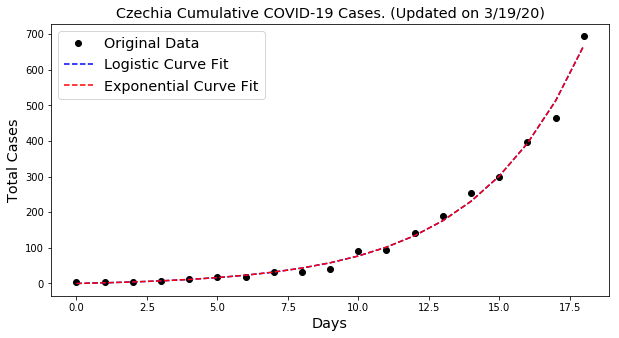



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 681
	Confirmed cases on 3/12/20 	 128
	Ratio: 5.32
	Weekly increase: 432.0 %
	Daily increase: 27.0 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.997865604069
	Doubling Time (represents overall growth):  3.2 (± 0.08 ) days


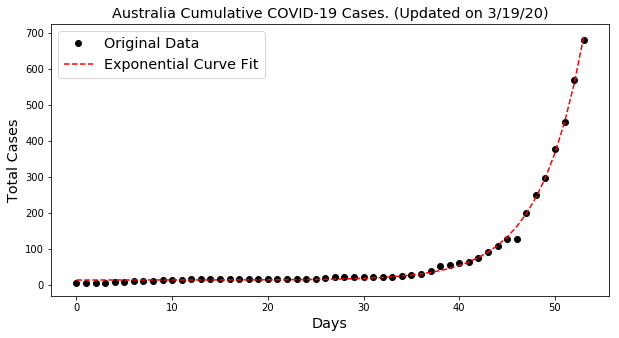



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 677
	Confirmed cases on 3/12/20 	 131
	Ratio: 5.17
	Weekly increase: 416.8 %
	Daily increase: 26.4 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.983062736455
	Doubling Time (during middle of growth):  5.54 (± 0.71 ) days

** Based on Exponential Fit **

	R^2: 0.983062736719
	Doubling Time (represents overall growth):  2.77 (± 0.31 ) days


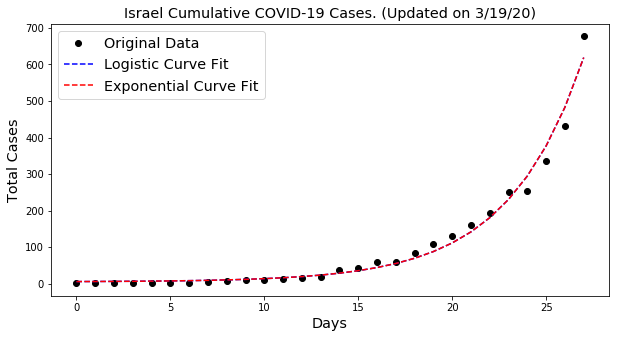



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 621
	Confirmed cases on 3/12/20 	 52
	Ratio: 11.94
	Weekly increase: 1094.2 %
	Daily increase: 42.5 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Exponential Fit **

	R^2: 0.980972847048
	Doubling Time (represents overall growth):  2.18 (± 0.29 ) days


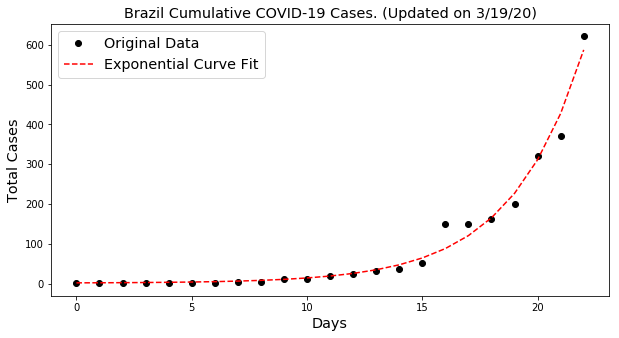



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 557
	Confirmed cases on 3/12/20 	 43
	Ratio: 12.95
	Weekly increase: 1195.3 %
	Daily increase: 44.2 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.973142121492
	Doubling Time (represents overall growth):  1.78 (± 0.31 ) days


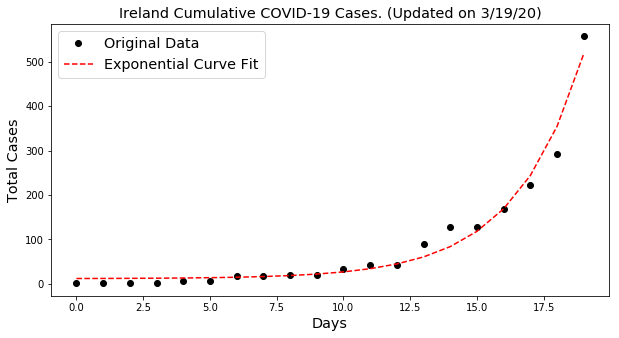



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 460
	Confirmed cases on 3/12/20 	 262
	Ratio: 1.76
	Weekly increase: 75.6 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.974186917348
	Doubling Time (during middle of growth):  1.77 (± 0.66 ) days


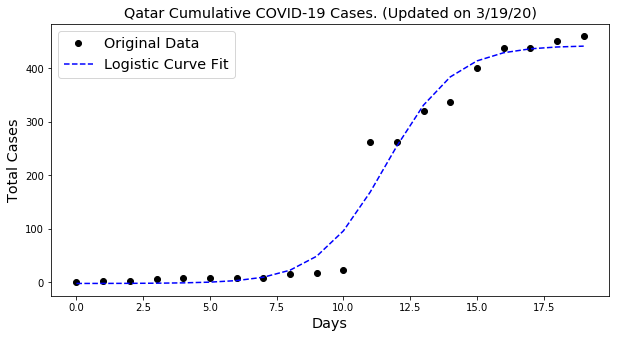



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 454
	Confirmed cases on 3/12/20 	 20
	Ratio: 22.7
	Weekly increase: 2170.0 %
	Daily increase: 56.2 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Exponential Fit **

	R^2: 0.988490998747
	Doubling Time (represents overall growth):  1.61 (± 0.16 ) days


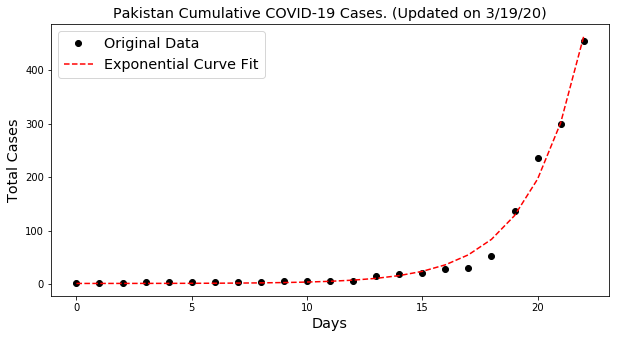



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 418
	Confirmed cases on 3/12/20 	 99
	Ratio: 4.22
	Weekly increase: 322.2 %
	Daily increase: 22.8 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.985684227554
	Doubling Time (during middle of growth):  3.27 (± 0.87 ) days

** Based on Exponential Fit **

	R^2: 0.964218739298
	Doubling Time (represents overall growth):  5.01 (± 1.28 ) days


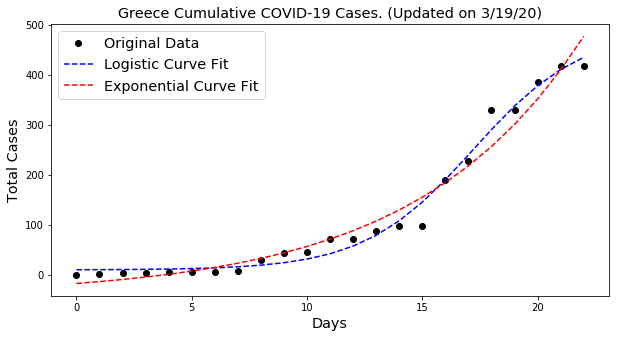



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 400
	Confirmed cases on 3/12/20 	 59
	Ratio: 6.78
	Weekly increase: 578.0 %
	Daily increase: 31.4 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Exponential Fit **

	R^2: 0.963793073495
	Doubling Time (represents overall growth):  3.54 (± 0.4 ) days


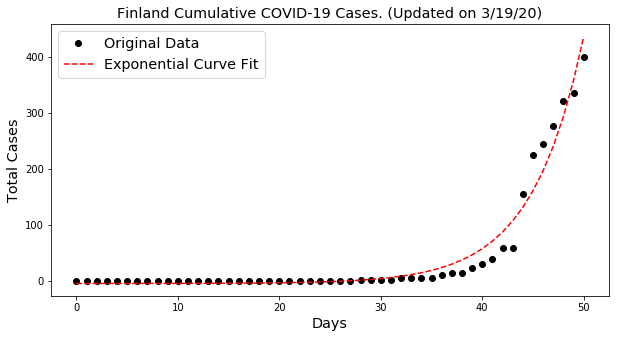



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 355
	Confirmed cases on 3/12/20 	 49
	Ratio: 7.24
	Weekly increase: 624.5 %
	Daily increase: 32.7 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.991943094236
	Doubling Time (during middle of growth):  4.28 (± 1.69 ) days

** Based on Exponential Fit **

	R^2: 0.99077495599
	Doubling Time (represents overall growth):  2.93 (± 0.42 ) days


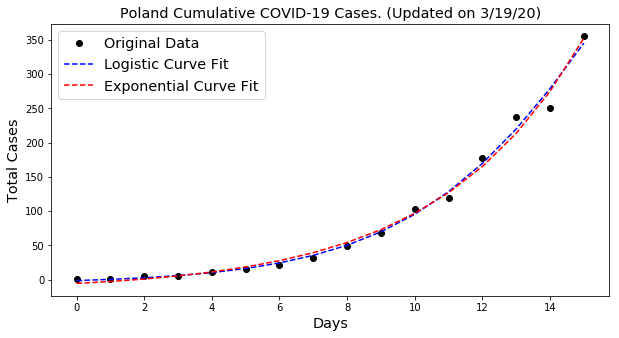



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 345
	Confirmed cases on 3/12/20 	 178
	Ratio: 1.94
	Weekly increase: 93.8 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.962220779121
	Doubling Time (during middle of growth):  23.89 (± 5.21 ) days

** Based on Exponential Fit **

	R^2: 0.962220780127
	Doubling Time (represents overall growth):  11.94 (± 1.85 ) days


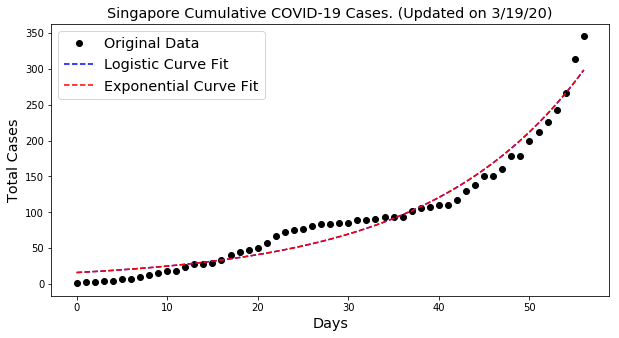



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 335
	Confirmed cases on 3/12/20 	 19
	Ratio: 17.63
	Weekly increase: 1663.2 %
	Daily increase: 50.7 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Exponential Fit **

	R^2: 0.995945211465
	Doubling Time (represents overall growth):  1.56 (± 0.1 ) days


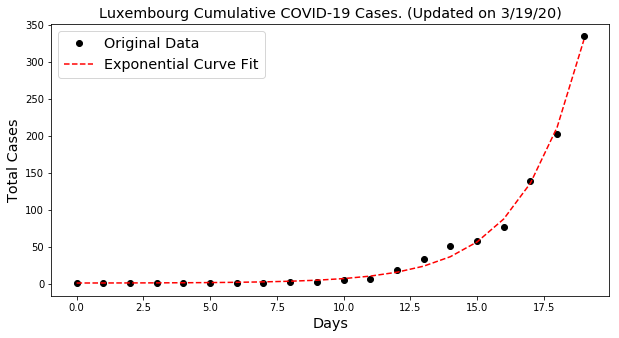



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 330
	Confirmed cases on 3/12/20 	 103
	Ratio: 3.2
	Weekly increase: 220.4 %
	Daily increase: 18.1 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.990218069988
	Doubling Time (during middle of growth):  9.81 (± 2.4 ) days

** Based on Exponential Fit **

	R^2: 0.990218070905
	Doubling Time (represents overall growth):  4.91 (± 0.71 ) days


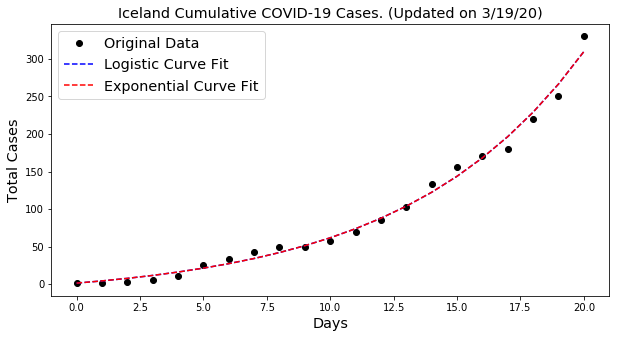



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 311
	Confirmed cases on 3/12/20 	 34
	Ratio: 9.15
	Weekly increase: 814.7 %
	Daily increase: 37.2 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.993890384631
	Doubling Time (during middle of growth):  5.5 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.99389038487
	Doubling Time (represents overall growth):  2.75 (± 0.27 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


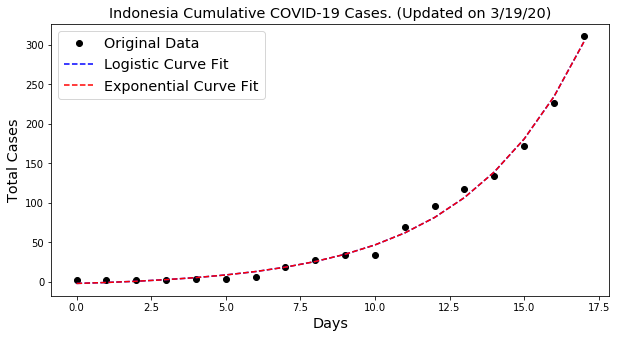



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 286
	Confirmed cases on 3/12/20 	 89
	Ratio: 3.21
	Weekly increase: 221.3 %
	Daily increase: 18.1 % per day
	Doubling Time (represents recent growth): 4.2 days

** Based on Logistic Fit**

	R^2: 0.999177547038
	Doubling Time (during middle of growth):  2.09 (± 0.16 ) days


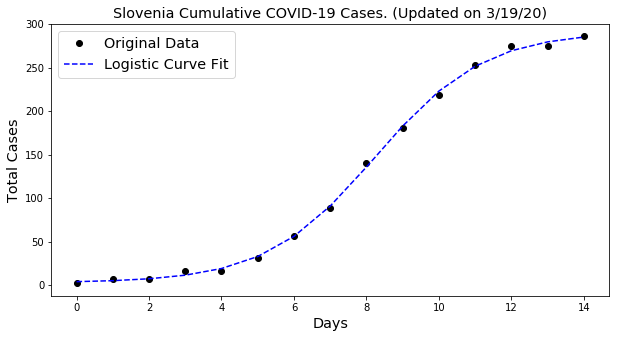



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 278
	Confirmed cases on 3/12/20 	 195
	Ratio: 1.43
	Weekly increase: 42.6 %
	Daily increase: 5.2 % per day
	Doubling Time (represents recent growth): 13.7 days

** Based on Logistic Fit**

	R^2: 0.968282670231
	Doubling Time (during middle of growth):  4.26 (± 1.61 ) days

** Based on Exponential Fit **

	R^2: 0.951161452849
	Doubling Time (represents overall growth):  10.63 (± 5.1 ) days


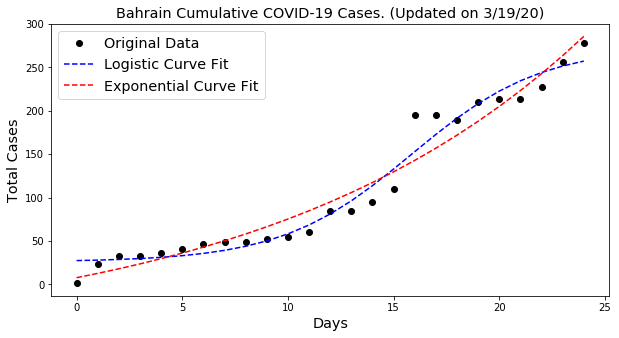



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 277
	Confirmed cases on 3/12/20 	 49
	Ratio: 5.65
	Weekly increase: 465.3 %
	Daily increase: 28.1 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.990543262162
	Doubling Time (during middle of growth):  4.09 (± 1.04 ) days

** Based on Exponential Fit **

	R^2: 0.984582376105
	Doubling Time (represents overall growth):  3.37 (± 0.45 ) days


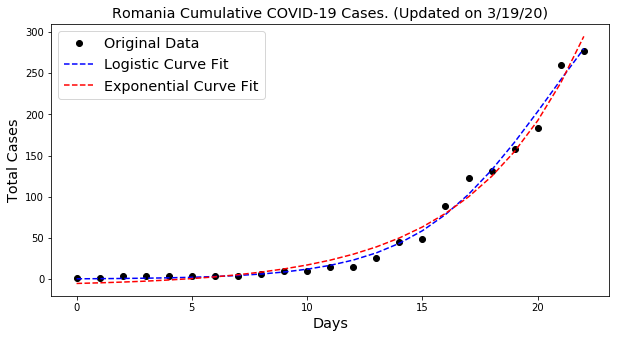



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 274
	Confirmed cases on 3/12/20 	 45
	Ratio: 6.09
	Weekly increase: 508.9 %
	Daily increase: 29.4 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.970299815214
	Doubling Time (during middle of growth):  6.43 (± 8.21 ) days

** Based on Exponential Fit **

	R^2: 0.970299817619
	Doubling Time (represents overall growth):  3.21 (± 0.77 ) days


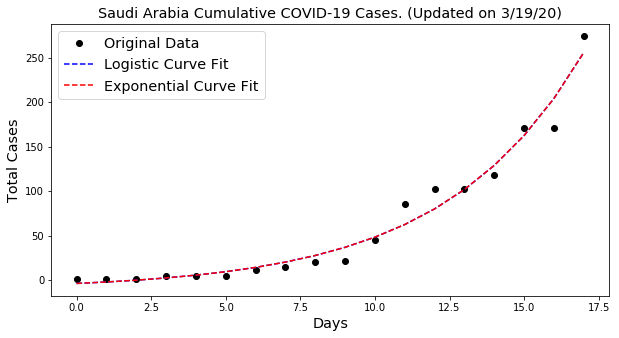



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 272
	Confirmed cases on 3/12/20 	 70
	Ratio: 3.89
	Weekly increase: 288.6 %
	Daily increase: 21.4 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Exponential Fit **

	R^2: 0.952809233035
	Doubling Time (represents overall growth):  2.88 (± 0.35 ) days


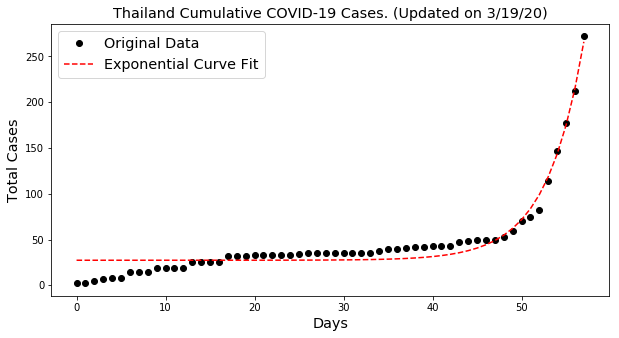



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 267
	Confirmed cases on 3/12/20 	 16
	Ratio: 16.69
	Weekly increase: 1568.8 %
	Daily increase: 49.5 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Logistic Fit**

	R^2: 0.994785546407
	Doubling Time (during middle of growth):  1.74 (± 0.28 ) days


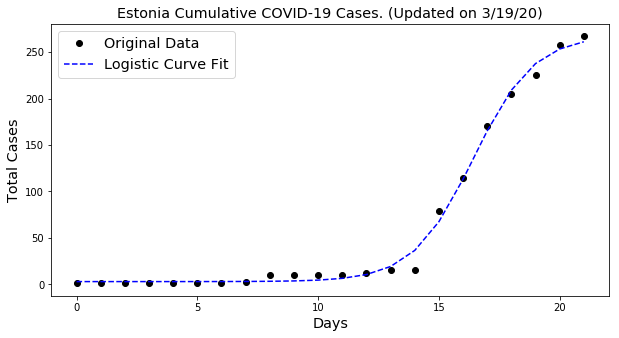



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 256
	Confirmed cases on 3/12/20 	 67
	Ratio: 3.82
	Weekly increase: 282.1 %
	Daily increase: 21.1 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.985441816429
	Doubling Time (during middle of growth):  6.63 (± 1.86 ) days

** Based on Exponential Fit **

	R^2: 0.98480365423
	Doubling Time (represents overall growth):  3.87 (± 0.37 ) days


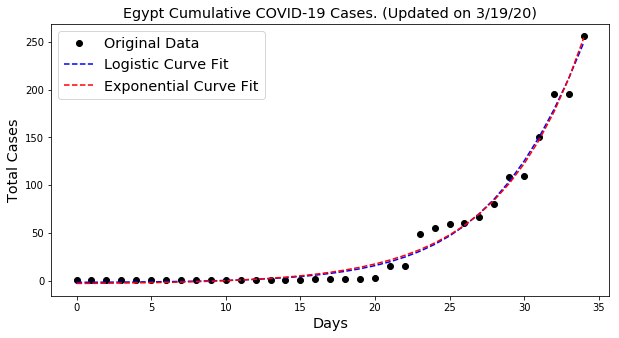



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 238
	Confirmed cases on 3/12/20 	 23
	Ratio: 10.35
	Weekly increase: 934.8 %
	Daily increase: 39.6 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.990095842427
	Doubling Time (during middle of growth):  1.69 (± 0.43 ) days

** Based on Exponential Fit **

	R^2: 0.954209709363
	Doubling Time (represents overall growth):  2.97 (± 0.91 ) days


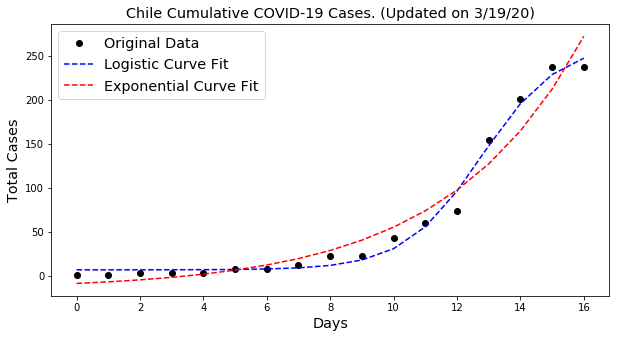



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 234
	Confirmed cases on 3/12/20 	 15
	Ratio: 15.6
	Weekly increase: 1460.0 %
	Daily increase: 48.1 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Logistic Fit**

	R^2: 0.992163219448
	Doubling Time (during middle of growth):  3.76 (± 1.19 ) days

** Based on Exponential Fit **

	R^2: 0.99216321993
	Doubling Time (represents overall growth):  1.88 (± 0.24 ) days


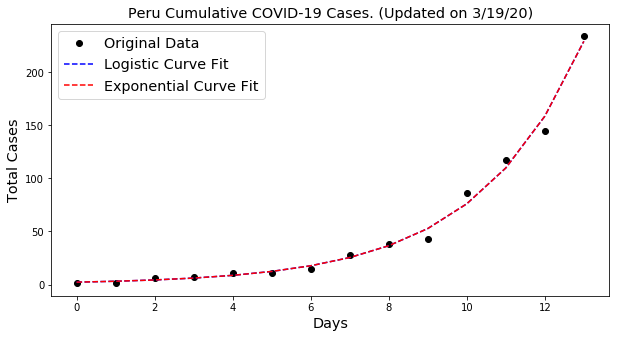



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 217
	Confirmed cases on 3/12/20 	 52
	Ratio: 4.17
	Weekly increase: 317.3 %
	Daily increase: 22.6 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.97162346627
	Doubling Time (represents overall growth):  3.48 (± 0.35 ) days


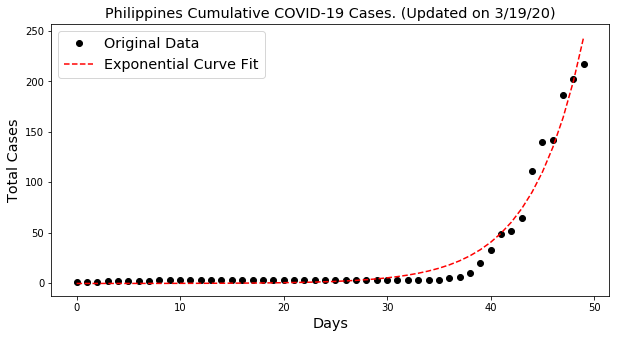



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 199
	Confirmed cases on 3/12/20 	 28
	Ratio: 7.11
	Weekly increase: 610.7 %
	Daily increase: 32.3 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Exponential Fit **

	R^2: 0.997022284856
	Doubling Time (represents overall growth):  2.59 (± 0.08 ) days


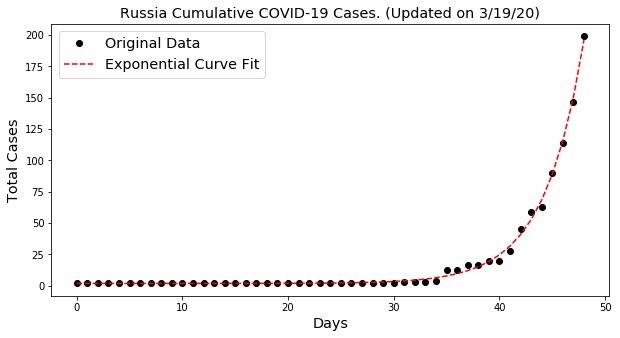



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 199
	Confirmed cases on 3/12/20 	 17
	Ratio: 11.71
	Weekly increase: 1070.6 %
	Daily increase: 42.1 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Exponential Fit **

	R^2: 0.993607710891
	Doubling Time (represents overall growth):  1.07 (± 0.09 ) days


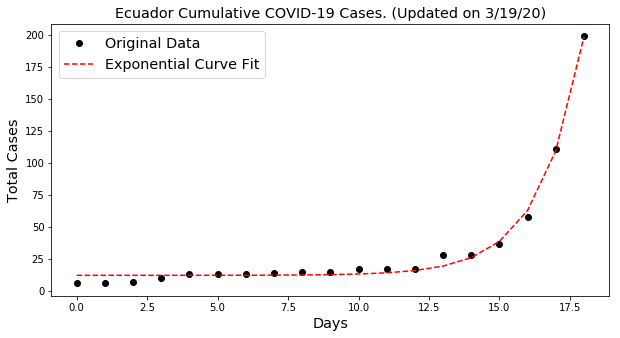



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 194
	Confirmed cases on 3/12/20 	 73
	Ratio: 2.66
	Weekly increase: 165.8 %
	Daily increase: 15.0 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Exponential Fit **

	R^2: 0.98975301564
	Doubling Time (represents overall growth):  4.74 (± 0.3 ) days


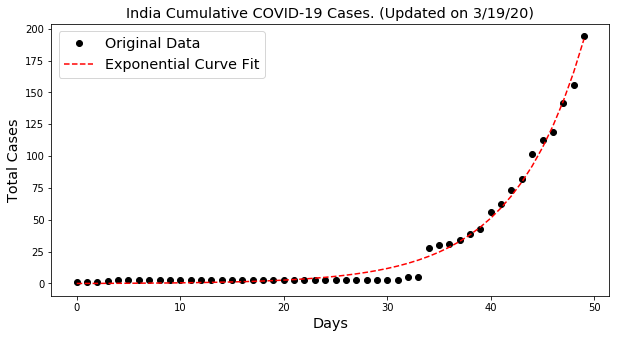



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 192
	Confirmed cases on 3/12/20 	 1
	Ratio: 192.0
	Weekly increase: 19100.0 %
	Daily increase: 111.9 % per day
	Doubling Time (represents recent growth): 0.9 days

** Based on Logistic Fit**

	R^2: 0.999348263022
	Doubling Time (during middle of growth):  1.48 (± 0.25 ) days

** Based on Exponential Fit **

	R^2: 0.99811352482
	Doubling Time (represents overall growth):  0.98 (± 0.08 ) days


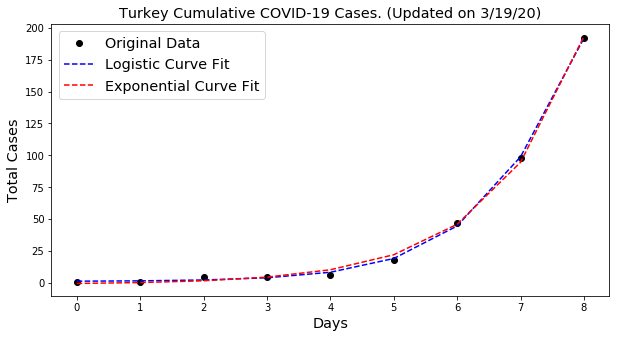



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 192
	Confirmed cases on 3/12/20 	 71
	Ratio: 2.7
	Weekly increase: 170.4 %
	Daily increase: 15.3 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Logistic Fit**

	R^2: 0.989907576805
	Doubling Time (during middle of growth):  14.52 (± 8.8 ) days

** Based on Exponential Fit **

	R^2: 0.989907578033
	Doubling Time (represents overall growth):  7.26 (± 1.13 ) days


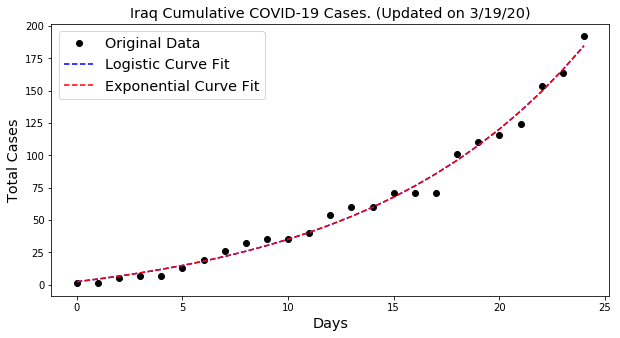



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 157
	Confirmed cases on 3/12/20 	 61
	Ratio: 2.57
	Weekly increase: 157.4 %
	Daily increase: 14.5 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Logistic Fit**

	R^2: 0.990075172462
	Doubling Time (during middle of growth):  6.36 (± 1.62 ) days

** Based on Exponential Fit **

	R^2: 0.985642316855
	Doubling Time (represents overall growth):  5.69 (± 0.78 ) days


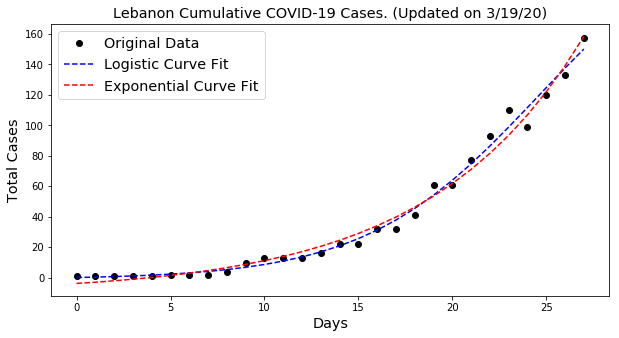



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 150
	Confirmed cases on 3/12/20 	 17
	Ratio: 8.82
	Weekly increase: 782.4 %
	Daily increase: 36.5 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.982262380134
	Doubling Time (during middle of growth):  4.68 (± 5.08 ) days

** Based on Exponential Fit **

	R^2: 0.982262381192
	Doubling Time (represents overall growth):  2.34 (± 0.45 ) days


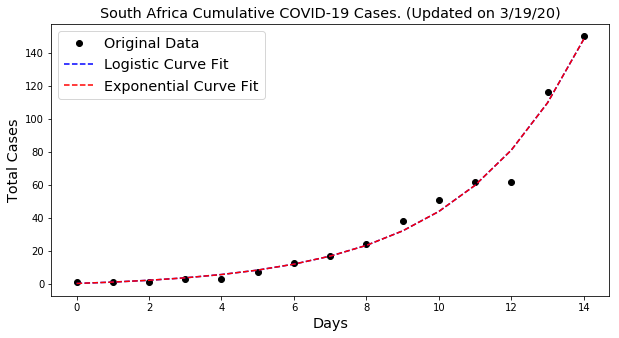



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 148
	Confirmed cases on 3/12/20 	 80
	Ratio: 1.85
	Weekly increase: 85.0 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days


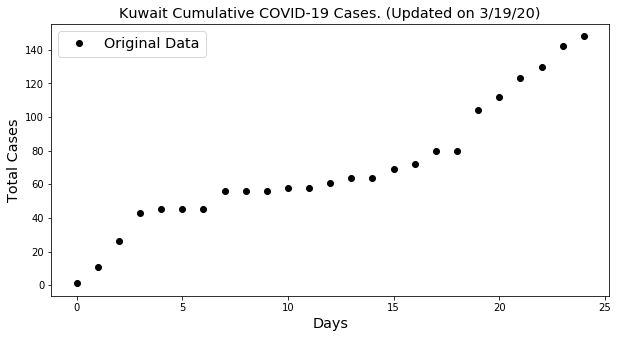



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 140
	Confirmed cases on 3/12/20 	 85
	Ratio: 1.65
	Weekly increase: 64.7 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.981535161871
	Doubling Time (during middle of growth):  7.87 (± 1.67 ) days

** Based on Exponential Fit **

	R^2: 0.975326254492
	Doubling Time (represents overall growth):  6.99 (± 0.75 ) days


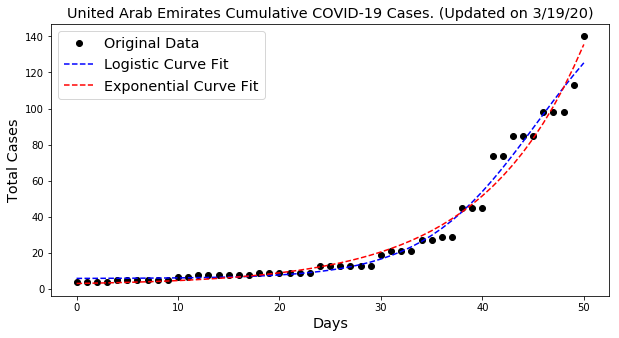



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 123
	Confirmed cases on 3/12/20 	 16
	Ratio: 7.69
	Weekly increase: 668.8 %
	Daily increase: 33.8 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.989256875787
	Doubling Time (during middle of growth):  5.22 (± 3.68 ) days

** Based on Exponential Fit **

	R^2: 0.988653316088
	Doubling Time (represents overall growth):  3.54 (± 0.75 ) days


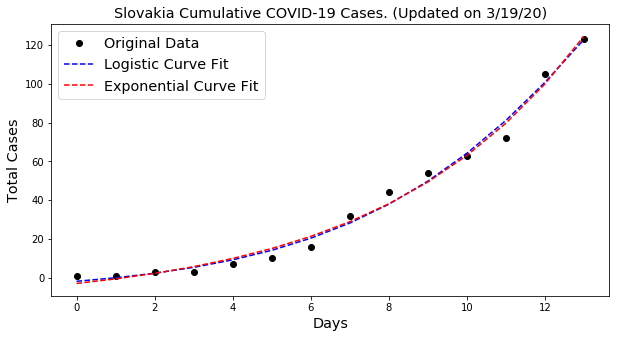



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 119
	Confirmed cases on 3/12/20 	 69
	Ratio: 1.72
	Weekly increase: 72.5 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.9 days

** Based on Logistic Fit**

	R^2: 0.993814277026
	Doubling Time (during middle of growth):  5.16 (± 1.11 ) days

** Based on Exponential Fit **

	R^2: 0.98081687872
	Doubling Time (represents overall growth):  11.78 (± 4.63 ) days


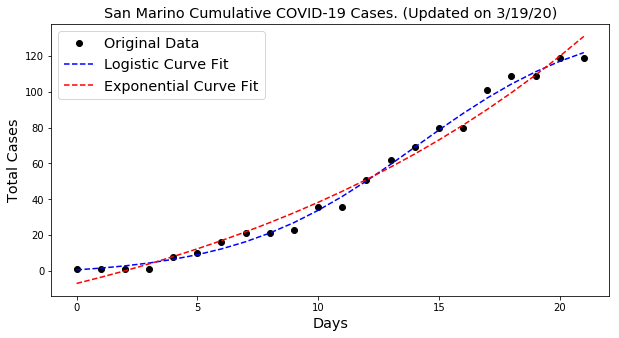



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 118
	Confirmed cases on 3/12/20 	 12
	Ratio: 9.83
	Weekly increase: 883.3 %
	Daily increase: 38.6 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.994934157005
	Doubling Time (during middle of growth):  2.29 (± 0.4 ) days

** Based on Exponential Fit **

	R^2: 0.981896068744
	Doubling Time (represents overall growth):  2.3 (± 0.32 ) days


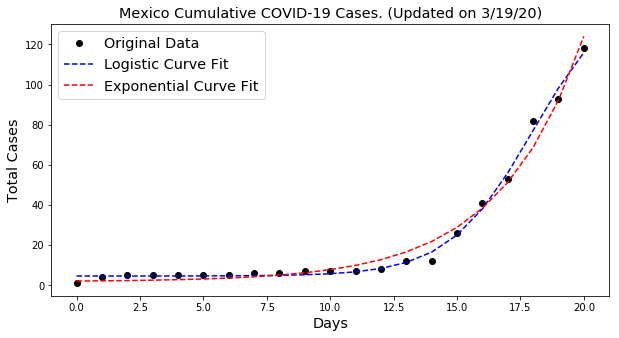



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 115
	Confirmed cases on 3/12/20 	 4
	Ratio: 28.75
	Weekly increase: 2775.0 %
	Daily increase: 61.6 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.991515786798
	Doubling Time (during middle of growth):  1.95 (± 0.46 ) days

** Based on Exponential Fit **

	R^2: 0.973635119133
	Doubling Time (represents overall growth):  2.15 (± 0.39 ) days


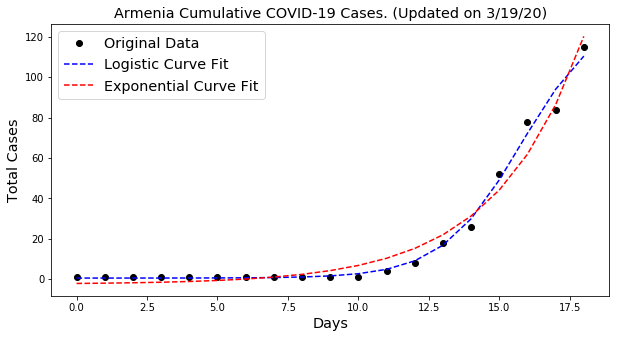



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 109
	Confirmed cases on 3/12/20 	 11
	Ratio: 9.91
	Weekly increase: 890.9 %
	Daily increase: 38.8 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.995271668103
	Doubling Time (during middle of growth):  9.65 (± 4.13 ) days

** Based on Exponential Fit **

	R^2: 0.995271668487
	Doubling Time (represents overall growth):  4.83 (± 1.43 ) days


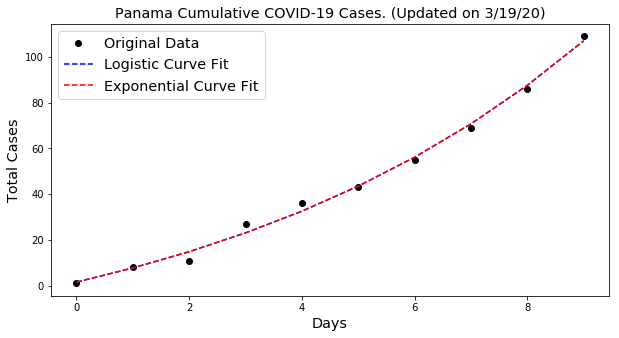



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 108
	Confirmed cases on 3/12/20 	 49
	Ratio: 2.2
	Weekly increase: 120.4 %
	Daily increase: 12.0 % per day
	Doubling Time (represents recent growth): 6.1 days


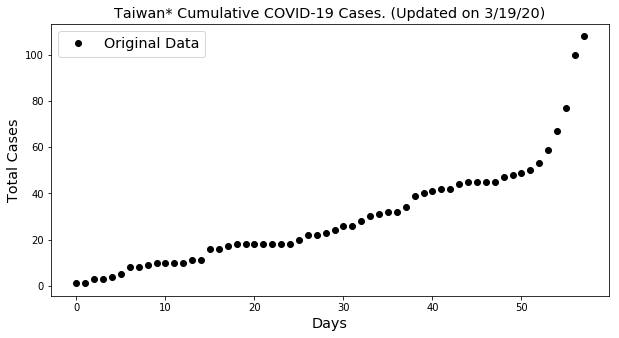



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 105
	Confirmed cases on 3/12/20 	 19
	Ratio: 5.53
	Weekly increase: 452.6 %
	Daily increase: 27.7 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.992079549555
	Doubling Time (during middle of growth):  6.19 (± 2.0 ) days

** Based on Exponential Fit **

	R^2: 0.992079506908
	Doubling Time (represents overall growth):  3.1 (± 0.28 ) days


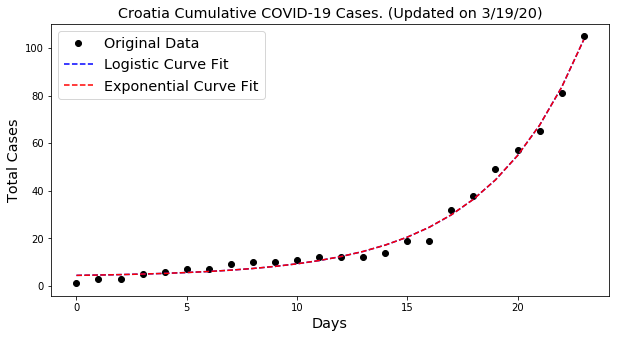



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 103
	Confirmed cases on 3/12/20 	 19
	Ratio: 5.42
	Weekly increase: 442.1 %
	Daily increase: 27.3 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.982288883406
	Doubling Time (during middle of growth):  6.84 (± 8.9 ) days

** Based on Exponential Fit **

	R^2: 0.981995876844
	Doubling Time (represents overall growth):  4.71 (± 1.58 ) days


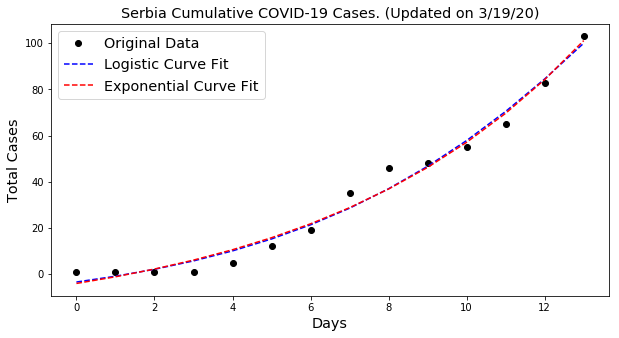



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 102
	Confirmed cases on 3/12/20 	 9
	Ratio: 11.33
	Weekly increase: 1033.3 %
	Daily increase: 41.5 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.995377809751
	Doubling Time (during middle of growth):  2.42 (± 0.55 ) days

** Based on Exponential Fit **

	R^2: 0.982871745292
	Doubling Time (represents overall growth):  2.78 (± 0.63 ) days


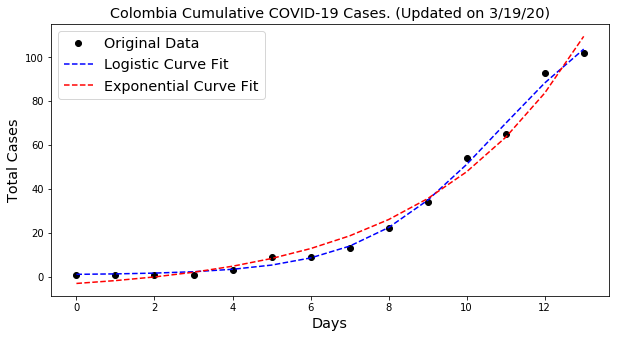

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


               Countries  Inferred Doubling Time  Recent Doubling Time
0                  China                     6.5                1755.5
1                  Italy                     6.6                   4.1
2                   Iran                     7.1                   8.1
3                  Spain                     3.0                   2.3
4                Germany                     2.7                   2.4
5                     US                     2.1                   2.3
6                 France                     3.4                   3.1
7           Korea, South                     4.2                  57.2
8            Switzerland                     3.4                   2.6
9         United Kingdom                     3.2                   2.7
10         

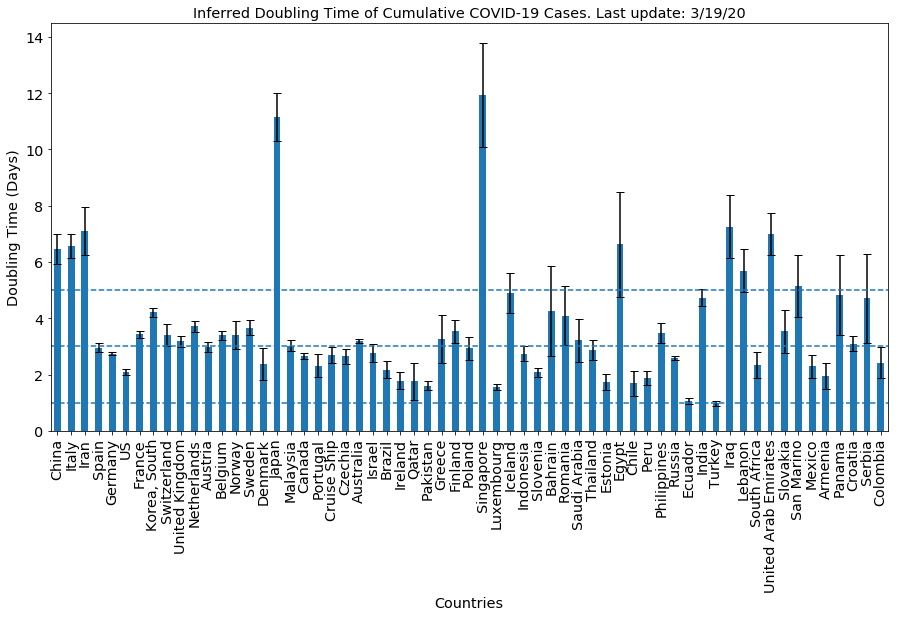

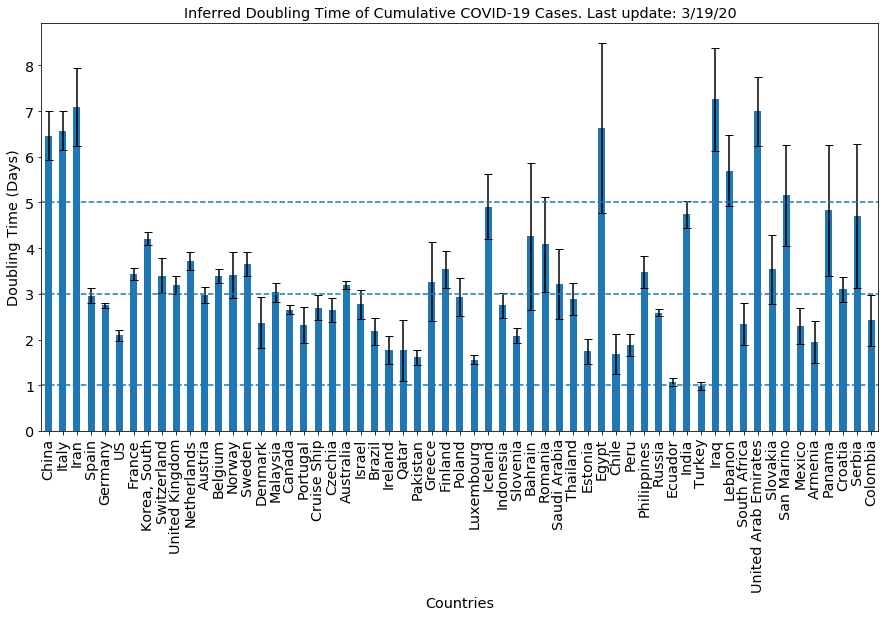

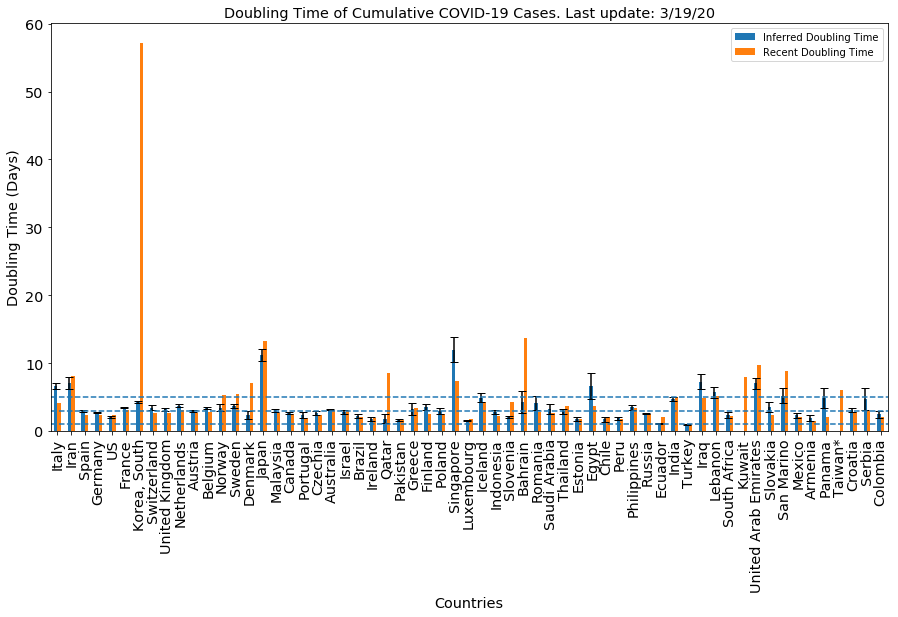

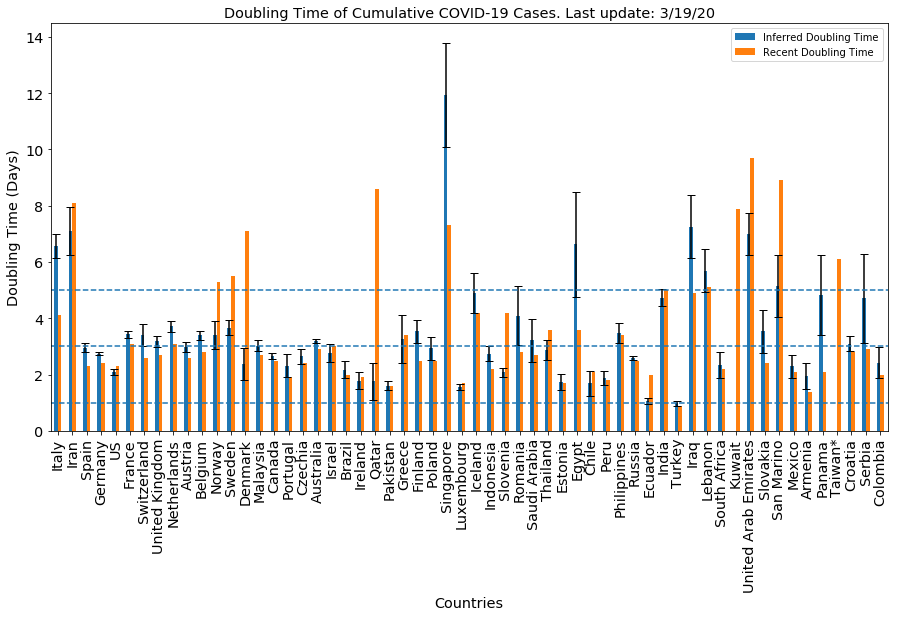

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/19/20


,3/19/20
Province/State,
New York,5365
Washington,1376
California,952
New Jersey,742
Illinois,422
Florida,417
Louisiana,392
Michigan,334
Massachusetts,328


## Curve Fitting US COVID-19 Cases

                3/19/20
Province/State         
New York           5365
Washington         1376
California          952
New Jersey          742
Illinois            422
Florida             417
Louisiana           392
Michigan            334
Massachusetts       328
Georgia             287
Colorado            277
Texas               260
Pennsylvania        206
Connecticut         159
Wisconsin           159
Tennessee           154
North Carolina      123
Ohio                119
Maryland            107


US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 5365
	Confirmed cases on 3/12/20 	 328
	Ratio: 16.36
	Weekly increase: 1535.7 %
	Daily increase: 49.1 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Exponential Fit **

	R^2: 0.988130730172
	Doubling Time (represents overall growth):  1.15 (± 0.14 ) days


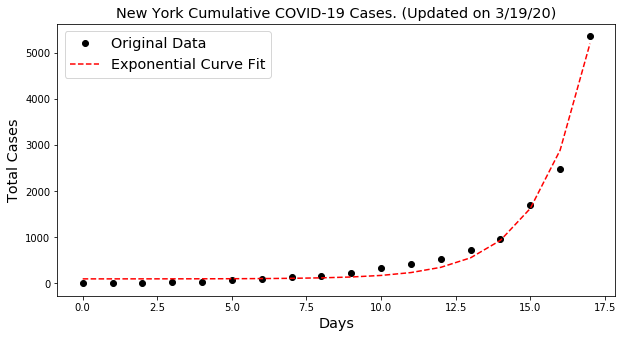



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 1376
	Confirmed cases on 3/12/20 	 442
	Ratio: 3.11
	Weekly increase: 211.3 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Exponential Fit **

	R^2: 0.983150754957
	Doubling Time (represents overall growth):  3.84 (± 0.28 ) days


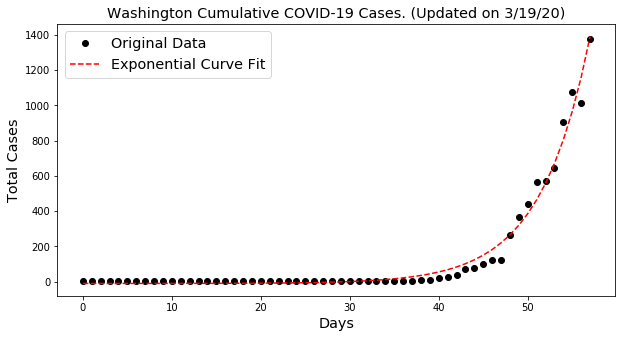



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 952
	Confirmed cases on 3/12/20 	 221
	Ratio: 4.31
	Weekly increase: 330.8 %
	Daily increase: 23.2 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.996439077138
	Doubling Time (represents overall growth):  3.33 (± 0.11 ) days


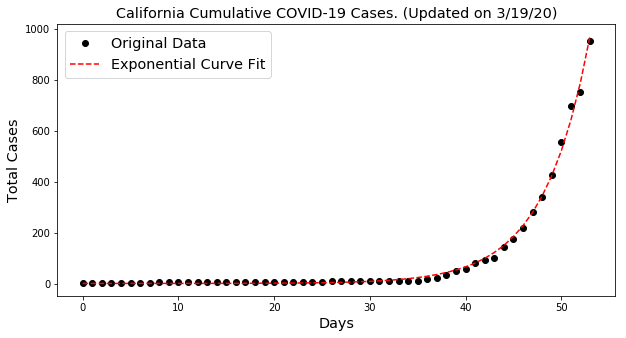



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 742
	Confirmed cases on 3/12/20 	 29
	Ratio: 25.59
	Weekly increase: 2458.6 %
	Daily increase: 58.9 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Exponential Fit **

	R^2: 0.956958995594
	Doubling Time (represents overall growth):  1.14 (± 0.3 ) days


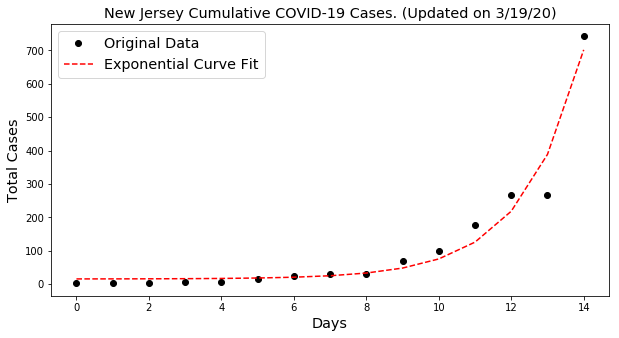



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 422
	Confirmed cases on 3/12/20 	 32
	Ratio: 13.19
	Weekly increase: 1218.8 %
	Daily increase: 44.6 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.955392835143
	Doubling Time (represents overall growth):  1.51 (± 0.18 ) days


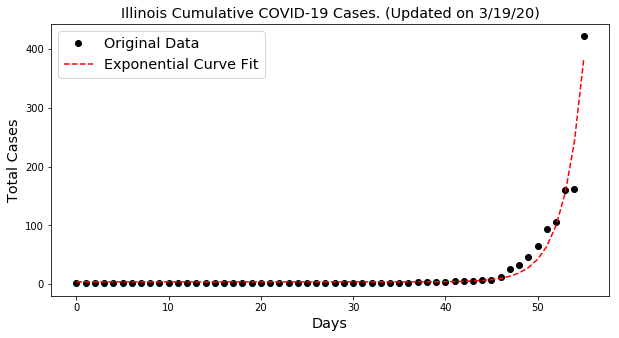



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 417
	Confirmed cases on 3/12/20 	 35
	Ratio: 11.91
	Weekly increase: 1091.4 %
	Daily increase: 42.5 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.999472288804
	Doubling Time (during middle of growth):  3.54 (± 0.29 ) days

** Based on Exponential Fit **

	R^2: 0.998907628473
	Doubling Time (represents overall growth):  2.09 (± 0.08 ) days


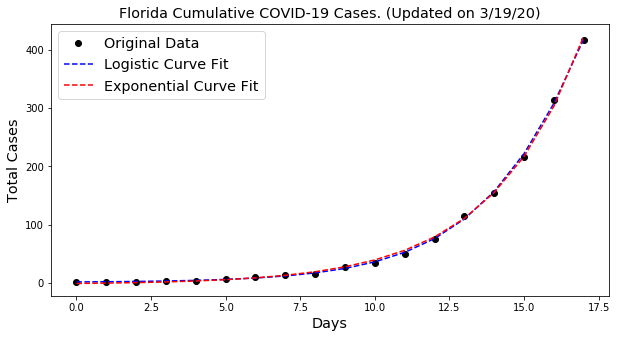



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 392
	Confirmed cases on 3/12/20 	 19
	Ratio: 20.63
	Weekly increase: 1963.2 %
	Daily increase: 54.1 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.995868369951
	Doubling Time (during middle of growth):  4.28 (± 1.13 ) days

** Based on Exponential Fit **

	R^2: 0.995868370096
	Doubling Time (represents overall growth):  2.14 (± 0.28 ) days


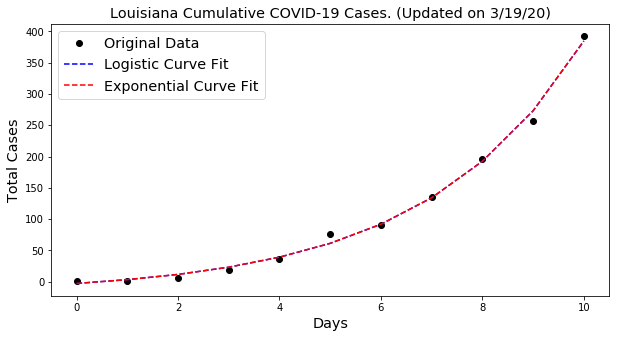



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 334
	Confirmed cases on 3/12/20 	 2
	Ratio: 167.0
	Weekly increase: 16600.0 %
	Daily increase: 107.7 % per day
	Doubling Time (represents recent growth): 0.9 days

** Based on Exponential Fit **

	R^2: 0.953420032799
	Doubling Time (represents overall growth):  0.77 (± 0.33 ) days


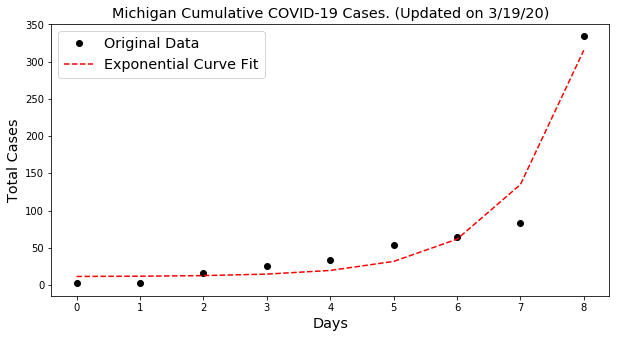



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 328
	Confirmed cases on 3/12/20 	 108
	Ratio: 3.04
	Weekly increase: 203.7 %
	Daily increase: 17.2 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Exponential Fit **

	R^2: 0.967544998021
	Doubling Time (represents overall growth):  3.87 (± 0.44 ) days


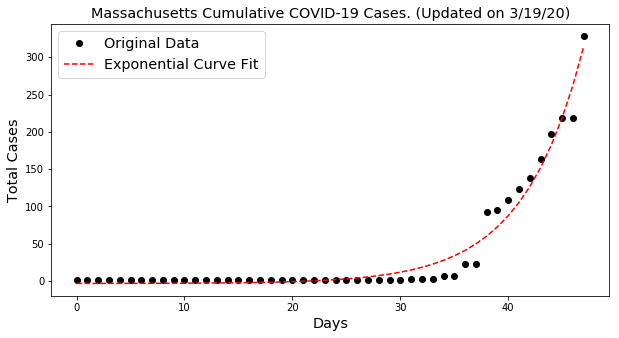



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 287
	Confirmed cases on 3/12/20 	 31
	Ratio: 9.26
	Weekly increase: 825.8 %
	Daily increase: 37.4 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.995373009361
	Doubling Time (during middle of growth):  4.76 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.995373009653
	Doubling Time (represents overall growth):  2.38 (± 0.21 ) days


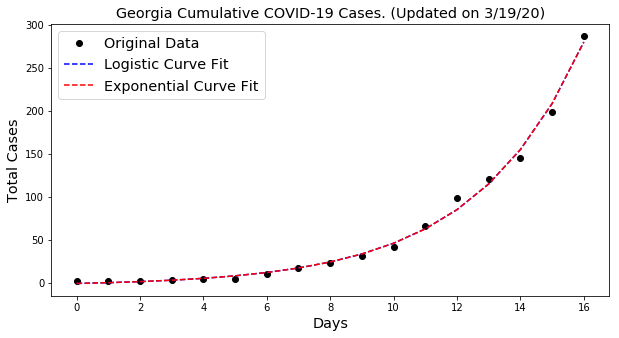



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 277
	Confirmed cases on 3/12/20 	 45
	Ratio: 6.16
	Weekly increase: 515.6 %
	Daily increase: 29.6 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.969146327707
	Doubling Time (during middle of growth):  6.53 (± 10.79 ) days

** Based on Exponential Fit **

	R^2: 0.969053465029
	Doubling Time (represents overall growth):  3.87 (± 1.47 ) days


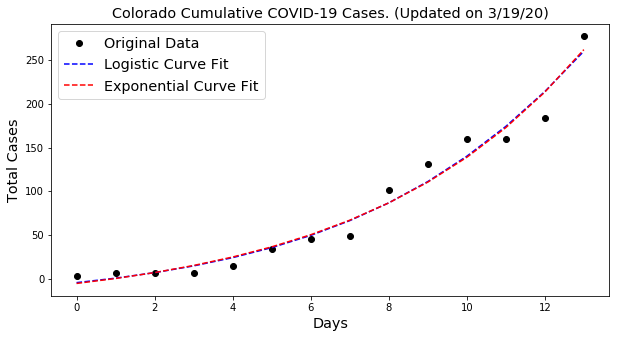



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 260
	Confirmed cases on 3/12/20 	 27
	Ratio: 9.63
	Weekly increase: 863.0 %
	Daily increase: 38.2 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.99141289542
	Doubling Time (during middle of growth):  3.79 (± 0.34 ) days

** Based on Exponential Fit **

	R^2: 0.991412895867
	Doubling Time (represents overall growth):  1.89 (± 0.24 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


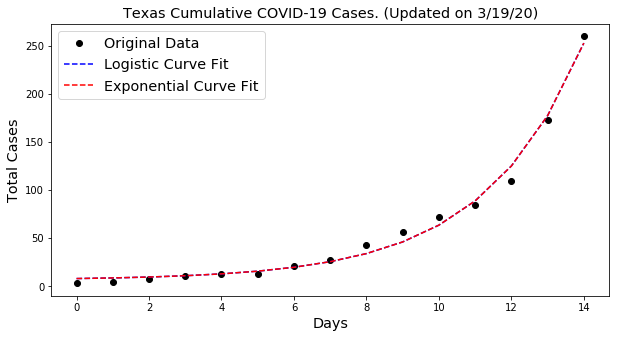



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 206
	Confirmed cases on 3/12/20 	 22
	Ratio: 9.36
	Weekly increase: 836.4 %
	Daily increase: 37.7 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.997302354837
	Doubling Time (during middle of growth):  4.78 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.997302355105
	Doubling Time (represents overall growth):  2.39 (± 0.2 ) days


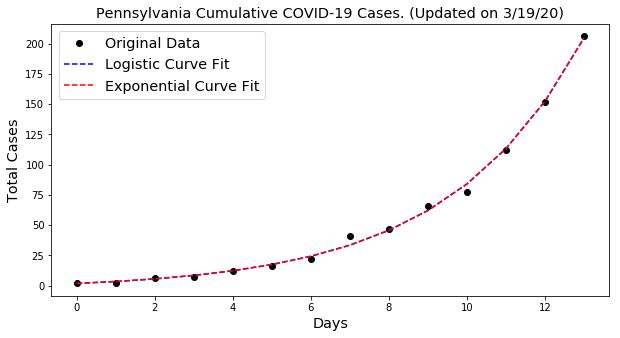



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 159
	Confirmed cases on 3/12/20 	 5
	Ratio: 31.8
	Weekly increase: 3080.0 %
	Daily increase: 63.9 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.960797767525
	Doubling Time (during middle of growth):  2.44 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.960797768724
	Doubling Time (represents overall growth):  1.22 (± 0.44 ) days


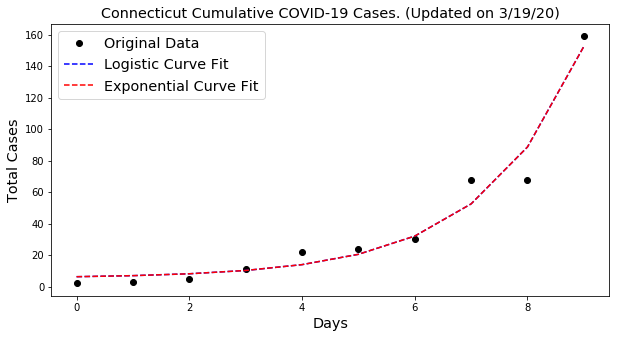



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 159
	Confirmed cases on 3/12/20 	 8
	Ratio: 19.88
	Weekly increase: 1887.5 %
	Daily increase: 53.3 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.99006724336
	Doubling Time (during middle of growth):  3.34 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.99006724423
	Doubling Time (represents overall growth):  1.67 (± 0.33 ) days


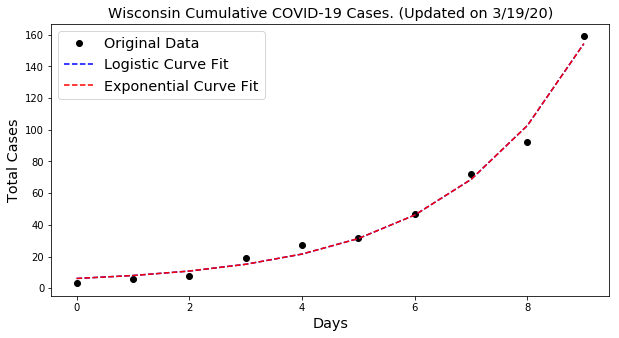



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 154
	Confirmed cases on 3/12/20 	 18
	Ratio: 8.56
	Weekly increase: 755.6 %
	Daily increase: 35.9 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.970025014209
	Doubling Time (during middle of growth):  3.99 (± 1.9 ) days

** Based on Exponential Fit **

	R^2: 0.970025015097
	Doubling Time (represents overall growth):  1.99 (± 0.48 ) days


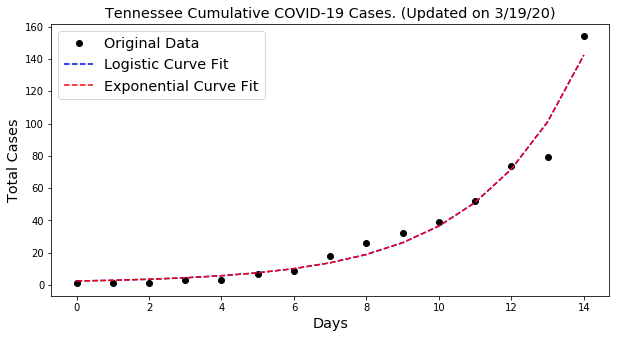



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 123
	Confirmed cases on 3/12/20 	 15
	Ratio: 8.2
	Weekly increase: 720.0 %
	Daily increase: 35.1 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.983826475596
	Doubling Time (during middle of growth):  3.99 (± 1.99 ) days

** Based on Exponential Fit **

	R^2: 0.98382647613
	Doubling Time (represents overall growth):  1.99 (± 0.31 ) days


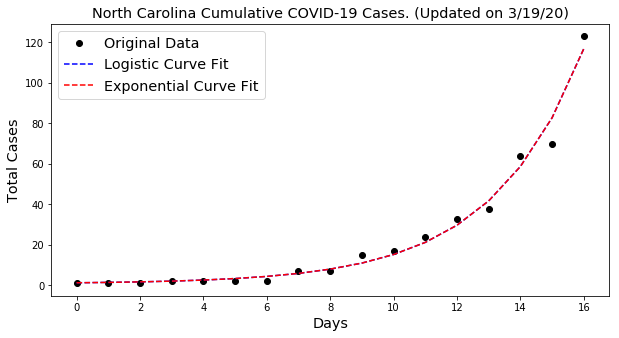



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 119
	Confirmed cases on 3/12/20 	 5
	Ratio: 23.8
	Weekly increase: 2280.0 %
	Daily increase: 57.3 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Logistic Fit**

	R^2: 0.996184528406
	Doubling Time (during middle of growth):  5.35 (± 5.17 ) days

** Based on Exponential Fit **

	R^2: 0.996177607747
	Doubling Time (represents overall growth):  2.81 (± 0.48 ) days


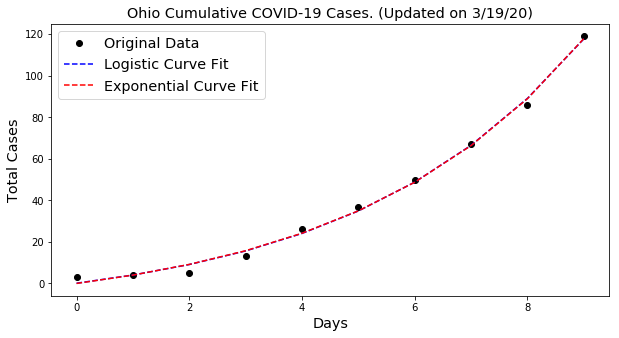



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/19/20 	 107
	Confirmed cases on 3/12/20 	 12
	Ratio: 8.92
	Weekly increase: 791.7 %
	Daily increase: 36.7 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.997597240168
	Doubling Time (during middle of growth):  3.73 (± 0.93 ) days

** Based on Exponential Fit **

	R^2: 0.997076003994
	Doubling Time (represents overall growth):  2.29 (± 0.19 ) days


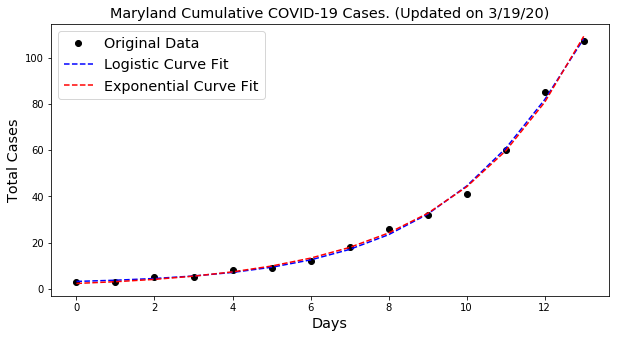

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


            States  Inferred Doubling Time  Recent Doubling Time
0         New York                     1.1                   1.7
1       Washington                     3.8                   4.3
2       California                     3.3                   3.3
3       New Jersey                     1.1                   1.5
4         Illinois                     1.5                   1.9
5          Florida                     2.1                   2.0
6        Louisiana                     2.1                   1.6
7         Michigan                     0.8                   0.9
8    Massachusetts                     3.9                   4.4
9          Georgia                     2.4                   2.2
10        Colorado                     3.9                   2.7
11          

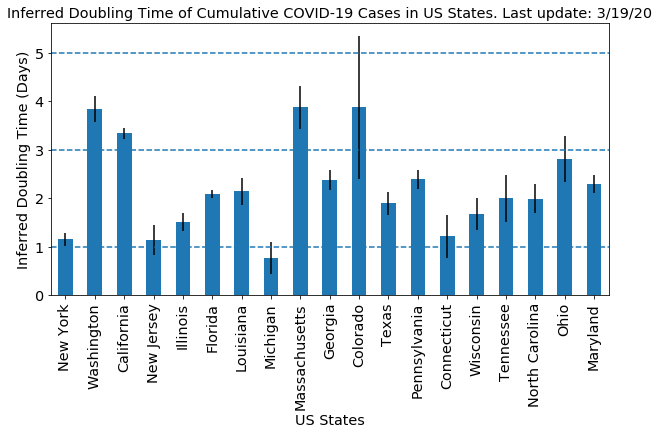

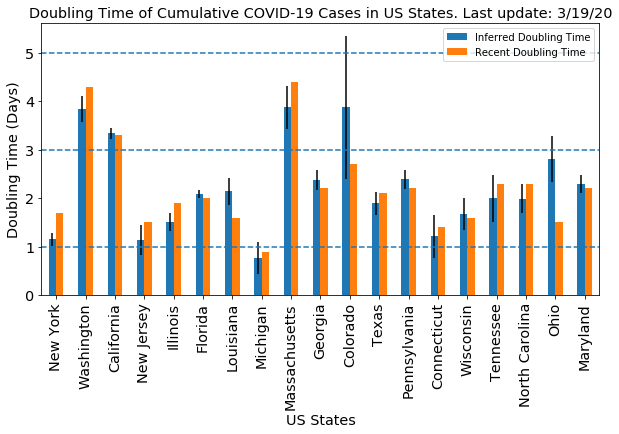

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()